# QFT Application: Hidden Patterns

Suppose we have a four-qubit quantum register containing one of the three states (A, B, or C):

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
import math
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_state_city, plot_histogram
from math import pi
from qiskit_aer import AerSimulator


simulator = AerSimulator()



In [2]:
def sig_a():
    A = QuantumCircuit(4, name='prepare A')
    for i in range(4):
        A.h(i)
    A.rz(math.radians(180), 0)
    return A

def sig_b():
    B = QuantumCircuit(4, name='prepare B')
    for i in range(4):
        B.h(i)
    B.rz(math.radians(90), 0)
    B.rz(math.radians(180), 1)
    return B


def sig_c():
    C = QuantumCircuit(4, name='Prepare C')
    for i in range(4):
        C.h(i)
    C.rz(math.radians(45), 0)
    C.rz(math.radians(90), 1)
    C.rz(math.radians(180), 2)
    return C

print(sig_a().draw())
print(sig_b().draw())
print(sig_c().draw())

     ┌───┐┌───────┐
q_0: ┤ H ├┤ Rz(π) ├
     ├───┤└───────┘
q_1: ┤ H ├─────────
     ├───┤         
q_2: ┤ H ├─────────
     ├───┤         
q_3: ┤ H ├─────────
     └───┘         
     ┌───┐┌─────────┐
q_0: ┤ H ├┤ Rz(π/2) ├
     ├───┤└┬───────┬┘
q_1: ┤ H ├─┤ Rz(π) ├─
     ├───┤ └───────┘ 
q_2: ┤ H ├───────────
     ├───┤           
q_3: ┤ H ├───────────
     └───┘           
     ┌───┐┌─────────┐
q_0: ┤ H ├┤ Rz(π/4) ├
     ├───┤├─────────┤
q_1: ┤ H ├┤ Rz(π/2) ├
     ├───┤└┬───────┬┘
q_2: ┤ H ├─┤ Rz(π) ├─
     ├───┤ └───────┘ 
q_3: ┤ H ├───────────
     └───┘           


Since the magnitudes of all values in each of these states are the same, the measurement results returns the same distribution for all three states.
 
**Note: here we use `save_statevector` to get the exact probabilities!**

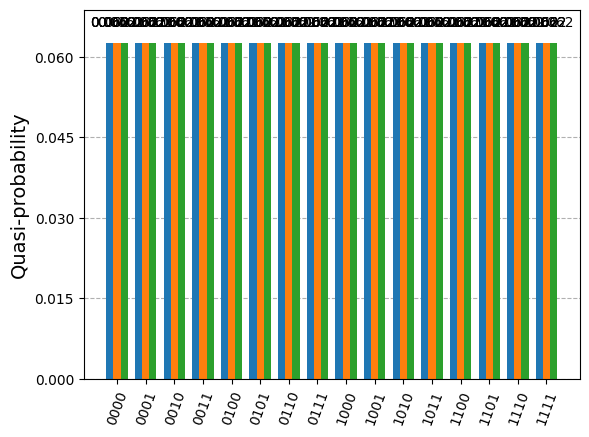

In [3]:

data = []
for sig in [sig_a(), sig_b(), sig_c()]:
    qc = QuantumCircuit(4)
    qc.append(sig, [0,1,2,3])
    qc.save_statevector()
    
    circ = transpile(qc, simulator)
    result = simulator.run(circ).result()
    counts = result.get_counts(circ)
    data.append(counts)

plot_histogram(data)

To distinguish these state we need to use the QFT primitive.

#### Solution

Use the QFT results obtained by reading the register allow us to precisely identify the initial state!

In [8]:
# First we define the QFT
def QFT(n):
    q = QuantumRegister(n, name='q')
    qft = QuantumCircuit(q, name='QFT')
    # QFT with n qubits
    # First we apply hadamard and control phase gates
    for j in range(n-1,-1,-1):
        qft.h(q[j])
        for k in range(j):
            qft.cp(pi / 2 ** (k + 1), q[j - 1 - k], q[j])
        qft.barrier()
    # Now finish the QFT by reversing the order of the qubits
    for j in range(n//2):
        qft.swap(q[j], q[n - j - 1])
        
    return qft

sig_after_qft = []
for sig in [sig_a(), sig_b(), sig_c()]:
    qc = QuantumCircuit(4)
    qc.append(sig, [0,1,2,3])
    qc.barrier()
    qc.append(QFT(4), [0, 1, 2, 3])
    sig_after_qft.append(qc)
    
for sig in sig_after_qft:
    print(sig.draw())

     ┌────────────┐ ░ ┌──────┐
q_0: ┤0           ├─░─┤0     ├
     │            │ ░ │      │
q_1: ┤1           ├─░─┤1     ├
     │  prepare A │ ░ │  QFT │
q_2: ┤2           ├─░─┤2     ├
     │            │ ░ │      │
q_3: ┤3           ├─░─┤3     ├
     └────────────┘ ░ └──────┘
     ┌────────────┐ ░ ┌──────┐
q_0: ┤0           ├─░─┤0     ├
     │            │ ░ │      │
q_1: ┤1           ├─░─┤1     ├
     │  prepare B │ ░ │  QFT │
q_2: ┤2           ├─░─┤2     ├
     │            │ ░ │      │
q_3: ┤3           ├─░─┤3     ├
     └────────────┘ ░ └──────┘
     ┌────────────┐ ░ ┌──────┐
q_0: ┤0           ├─░─┤0     ├
     │            │ ░ │      │
q_1: ┤1           ├─░─┤1     ├
     │  Prepare C │ ░ │  QFT │
q_2: ┤2           ├─░─┤2     ├
     │            │ ░ │      │
q_3: ┤3           ├─░─┤3     ├
     └────────────┘ ░ └──────┘


In [5]:


for sig in sig_after_qft:
    statevector = Statevector(sig)
    s = ""
    prob = 0
    for i in range(16):
        amp = statevector.data[i]
        if abs(amp) > 0.01:
            s += f"({statevector.data[i]:.3f})|{bin(i)[2:].zfill(3)}> + "
            prob += (abs(amp) * abs(amp))
    print("---")
    print(f"{s[:-3]}, prob = {round(prob * 100, 5)}")
    





---
(0.000-1.000j)|1000>, prob = 100.0
---
(-0.707-0.707j)|1100>, prob = 100.0
---
(-0.924-0.383j)|1110>, prob = 100.0


Finally, we can execute the circuit with the measurement obtaining:

        ┌────────────┐┌──────┐ ░ ┌─┐         
   q_0: ┤0           ├┤0     ├─░─┤M├─────────
        │            ││      │ ░ └╥┘┌─┐      
   q_1: ┤1           ├┤1     ├─░──╫─┤M├──────
        │  prepare A ││  QFT │ ░  ║ └╥┘┌─┐   
   q_2: ┤2           ├┤2     ├─░──╫──╫─┤M├───
        │            ││      │ ░  ║  ║ └╥┘┌─┐
   q_3: ┤3           ├┤3     ├─░──╫──╫──╫─┤M├
        └────────────┘└──────┘ ░  ║  ║  ║ └╥┘
meas: 4/══════════════════════════╩══╩══╩══╩═
                                  0  1  2  3 
        ┌────────────┐┌──────┐ ░ ┌─┐         
   q_0: ┤0           ├┤0     ├─░─┤M├─────────
        │            ││      │ ░ └╥┘┌─┐      
   q_1: ┤1           ├┤1     ├─░──╫─┤M├──────
        │  prepare B ││  QFT │ ░  ║ └╥┘┌─┐   
   q_2: ┤2           ├┤2     ├─░──╫──╫─┤M├───
        │            ││      │ ░  ║  ║ └╥┘┌─┐
   q_3: ┤3           ├┤3     ├─░──╫──╫──╫─┤M├
        └────────────┘└──────┘ ░  ║  ║  ║ └╥┘
meas: 4/══════════════════════════╩══╩══╩══╩═
                                  

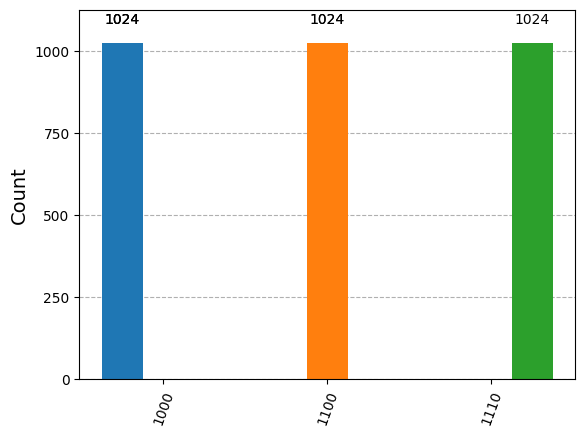

In [6]:
simulator = AerSimulator()

data = []
for sig in sig_after_qft:
    qc = sig.copy()
    qc.measure_all()
    print(qc.draw())
    circ = transpile(qc, simulator)
    result = simulator.run(circ).result()
    counts = result.get_counts(circ)
    data.append(counts)

plot_histogram(data)

After having adding the QFT, we can check the state of our tree signal